In [0]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2

--2019-04-29 10:54:56--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  7.30MB/s    in 2m 6s   

2019-04-29 10:57:08 (9.42 MB/s) - ‘RML2016.10b.tar.bz2’ saved [1245608913/1245608913]



In [0]:
import tarfile
tar = tarfile.open("RML2016.10b.tar.bz2", "r:bz2")
tar.extractall()
tar.close()

In [0]:
import keras
import numpy as np
import theano as th
import pickle
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from sklearn import preprocessing
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("RML2016.10b.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [0]:
X1 = np.apply_along_axis(np.gradient, 1, X)
for i in range(len(X)):
  X[i] = X[i] + X1[i]

In [26]:
print X.shape
print lbl[2]
#print X[2]

(1200000, 2, 128)
('8PSK', -20)


In [0]:
#spliting data even odd 50%
def splitData(X):
  #for even
  trainingSet = X[::2] 
  #for odd
  testSet = X[1::2] 
  trainingLabel = np.array(lbl[::2])
  testLabel = np.array(lbl[1::2])
  #validationSet = testSet[0:30000]
  lb = preprocessing.LabelBinarizer()
  label = lb.fit_transform(trainingLabel[:,0])
  
  #print trainingSet[0]
  #print testSet[0]
  print label[0]
  print label.shape
  print trainingSet.shape
  print testSet.shape
  print trainingLabel.shape
  print testLabel.shape
  #print validationSet.shape
  return trainingSet, testSet, trainingLabel, testLabel, label 

In [0]:
trainingSet, testSet, trainingLabel, testLabel, label = splitData(X)

[1 0 0 0 0 0 0 0 0 0]
(600000, 10)
(600000, 2, 128)
(600000, 2, 128)
(600000, 2)
(600000, 2)


In [0]:
model = Sequential()
model.add(Dense(512, input_shape=(2,128), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Fit the model
history = model.fit(trainingSet, label, epochs=60, batch_size=20, validation_split=0.005, callbacks=[EarlyStopping(patience=5,  mode='min')])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 2, 512)            66048     
_________________________________________________________________
dense_68 (Dense)             (None, 2, 256)            131328    
_________________________________________________________________
flatten_23 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
Train on 597000 samples, validate on 3000 samples
Epoch 1/60
597000/597000 [==============================] - 191s 320us/step - loss: 1.5330 - acc: 0.3765 - val_loss: 0.7305 - val_acc: 0.3377
Epoch 2/60
597000/597000 [==============================] - 185s 310us/step 

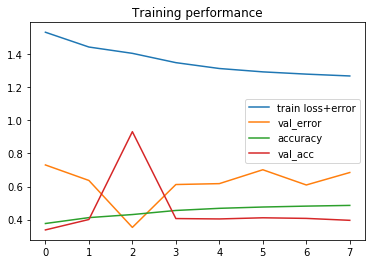

In [0]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.plot(history.epoch, history.history['acc'], label='accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='val_acc')
plt.legend()